In [1]:
%matplotlib notebook
import numpy as np
import glob, os, copy
from matplotlib import pyplot as plt
import init_cfg as ic
from astropy.io import fits
from astropy.convolution import convolve
from astropy.convolution import Gaussian1DKernel


# ----- Reading the cube ----- #
fin_cb = 'fcube_3D.fits'

hd0 = fits.getheader(fin_cb, ext=0)
d_sci, h_sci = fits.getdata(fin_cb, ext=1, header=True)
d_var, h_var = fits.getdata(fin_cb, ext=2, header=True)

wav = np.linspace(start=h_sci['CRVAL3']+(1-h_sci['CRPIX3'])*h_sci['CD3_3'],
                  stop=h_sci['CRVAL3']+(h_sci['NAXIS3']-h_sci['CRPIX3'])*h_sci['CD3_3'],
                  num=h_sci['NAXIS3'], endpoint=True)

In [2]:
# ----- Blank region subtraction ----- #
def sub_blank(cube_sci, cube_var, blk_width, blk_height,
              ll=True, lu=True, rl=True, ru=True,
              ll_x0=1, ll_y0=1, lu_x0=1, lu_y0=-1,
              rl_x0=-1, rl_y0=1, ru_x0=-1, ru_y0=-1,
              edge0=False, boundary_smooth=True):
    
    cube_sci_sb = copy.deepcopy(cube_sci)
    cube_var_sb = copy.deepcopy(cube_var)
    
    lslit_lower = np.median(cube_sci[:, ll_y0:ll_y0+blk_height, ll_x0:ll_x0+blk_width],
                            axis=(1,2))
    lslit_lower_var = np.sum(cube_var[:, ll_y0:ll_y0+blk_height, ll_x0:ll_x0+blk_width],
                             axis=(1,2)) / (blk_width*blk_height)**2.
    lslit_upper = np.median(cube_sci[:, lu_y0-blk_height:lu_y0, lu_x0:lu_x0+blk_width],
                            axis=(1,2))
    lslit_upper_var = np.sum(cube_var[:, lu_y0-blk_height:lu_y0, lu_x0:lu_x0+blk_width],
                             axis=(1,2)) / (blk_width*blk_height)**2.
       
    if (ll & lu):
        lslit_blank = 0.5*(lslit_lower + lslit_upper)
        lslit_blank_var = 0.25*(lslit_lower_var + lslit_upper_var)
    elif ((ll == True) & (lu == False)):
        lslit_blank = lslit_lower
        lslit_blank_var = lslit_lower_var
    elif ((ll == False) & (lu == True)):
        lslit_blank = lslit_upper
        lslit_blank_var = lslit_upper_var

    rslit_lower = np.median(cube_sci[:, rl_y0:rl_y0+blk_height, rl_x0-blk_width:rl_x0],
                            axis=(1,2))
    rslit_lower_var = np.sum(cube_var[:, rl_y0:rl_y0+blk_height, rl_x0-blk_width:rl_x0],
                             axis=(1,2)) / (blk_width*blk_height)**2.
    rslit_upper = np.median(cube_sci[:, ru_y0-blk_height:ru_y0, ru_x0-blk_width:ru_x0],
                            axis=(1,2))
    rslit_upper_var = np.sum(cube_var[:, ru_y0-blk_height:ru_y0, ru_x0-blk_width:ru_x0],
                             axis=(1,2)) / (blk_width*blk_height)**2.

    if (rl & ru):
        rslit_blank = 0.5*(rslit_lower + rslit_upper)
        rslit_blank_var = 0.25*(rslit_lower_var + rslit_upper_var)
    elif ((rl == True) & (ru == False)):
        rslit_blank = rslit_lower
        rslit_blank_var = rslit_lower_var
    elif ((rl == False) & (ru == True)):
        rslit_blank = rslit_upper
        rslit_blank_var = rslit_upper_var

    for x in np.arange(cube_sci.shape[2]):
        for y in np.arange(cube_sci.shape[1]):
            if (x < cube_sci.shape[2]/2):
                sub_blank = lslit_blank
                sub_blank_var = lslit_blank_var
            elif (x >= cube_sci.shape[2]/2):
                sub_blank = rslit_blank
                sub_blank_var = rslit_blank_var
            cube_sci_sb[:, y, x] = cube_sci[:, y, x] - sub_blank
            cube_var_sb[:, y, x] = cube_var[:, y, x] + sub_blank_var
    
    if edge0:
        cube_sci_sb[:, 0, :] = 0.
        cube_sci_sb[:, :, 0] = 0.
        cube_sci_sb[:, -1, :] = 0.
        cube_sci_sb[:, :, -1] = 0.
    
    if boundary_smooth:
        from astropy.convolution import Gaussian1DKernel
        from astropy.convolution import convolve
        from tqdm import trange
        
        kernel = Gaussian1DKernel(2)
        xidx_range = [33, 35]

        for spx in trange(cube_sci.shape[0]):
            for y in np.arange(cube_sci.shape[1]):
                lshot = copy.deepcopy(cube_sci_sb[spx, y, :])
                lshot[xidx_range[0]:xidx_range[1]] = np.nan
                lshot_conv = convolve(lshot, kernel)
                lshot[xidx_range[0]:xidx_range[1]] = lshot_conv[xidx_range[0]:xidx_range[1]]
                cube_sci_sb[spx, y, :] = lshot
    
    return [cube_sci_sb, cube_var_sb, lslit_blank, rslit_blank]

# sub_blank(cube_sci, cube_var, blk_width, blk_height,
#               ll=True, lu=True, rl=True, ru=True,
#               ll_x0=1, ll_y0=1, lu_x0=1, lu_y0=-1,
#               rl_x0=-1, rl_y0=1, ru_x0=-1, ru_y0=-1,
#               edge0=False, boundary_smooth=True)
d_sci_sb, d_var_sb, lslit_blank, rslit_blank = sub_blank(d_sci, d_var, 6, 14, edge0=False)

100%|██████████| 4591/4591 [01:02<00:00, 74.05it/s]


In [3]:
# ----- Saving blank region subtracted cubes ----- #
nhd0 = fits.PrimaryHDU()
nhd1 = fits.ImageHDU()
nhd2 = fits.ImageHDU()

nhd0.header = hd0

nhd1.data = d_sci_sb
nhd1.header = h_sci

nhd2.data = d_var_sb
nhd2.header = h_var

nhdu = fits.HDUList([nhd0, nhd1, nhd2])
nhdu.writeto('bfcube_3D.fits', overwrite=True)

<IPython.core.display.Javascript object>


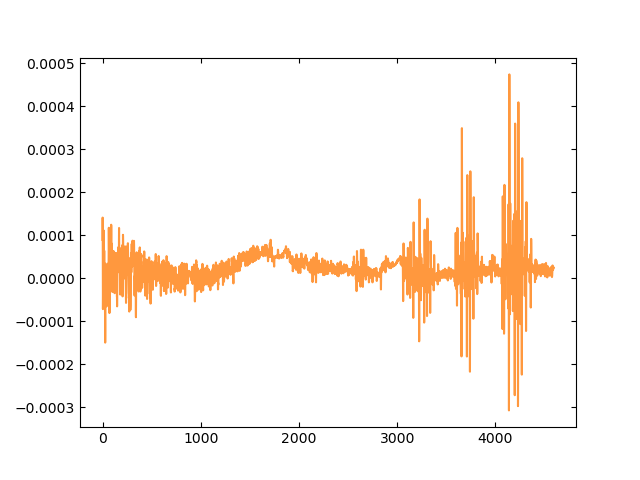

In [4]:
# ----- Ploting the left slit blank region ----- #
fig, ax = plt.subplots()
# ax.plot(lslit_lower, alpha=0.6)
# ax.plot(lslit_upper, alpha=0.6)
ax.plot(lslit_blank, alpha=0.8, color='C1')

<IPython.core.display.Javascript object>


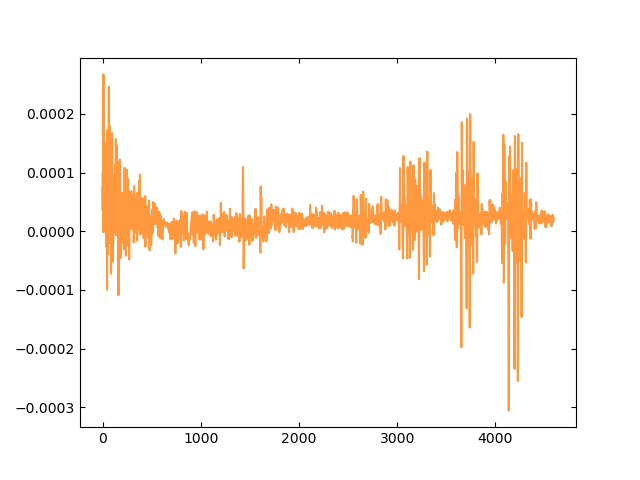

In [5]:
# ----- Ploting the right slit blank region ----- #
fig, ax = plt.subplots()
# ax.plot(rslit_lower, alpha=0.6)
# ax.plot(rslit_upper, alpha=0.6)
ax.plot(rslit_blank, alpha=0.8, color='C1')

<IPython.core.display.Javascript object>


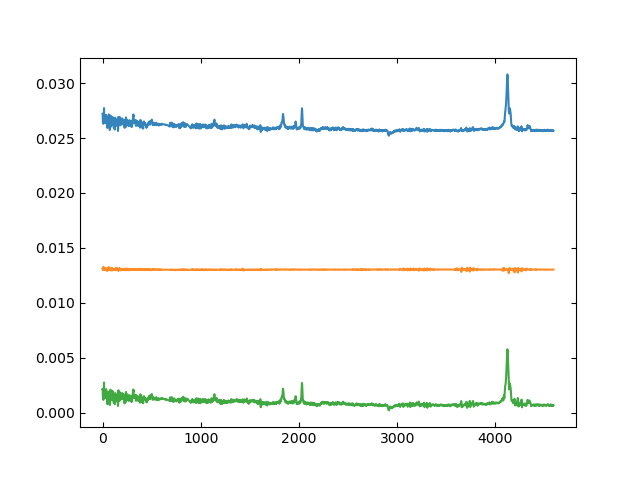

In [6]:
# ----- Plotting the right slit spectra ----- #
fig, ax = plt.subplots()
ax.plot(d_sci[:, 30-1, 37-1]+0.025, alpha=0.9)
ax.plot(rslit_blank+0.013, alpha=0.9)
ax.plot(d_sci_sb[:, 30-1, 37-1], alpha=0.9)

<IPython.core.display.Javascript object>


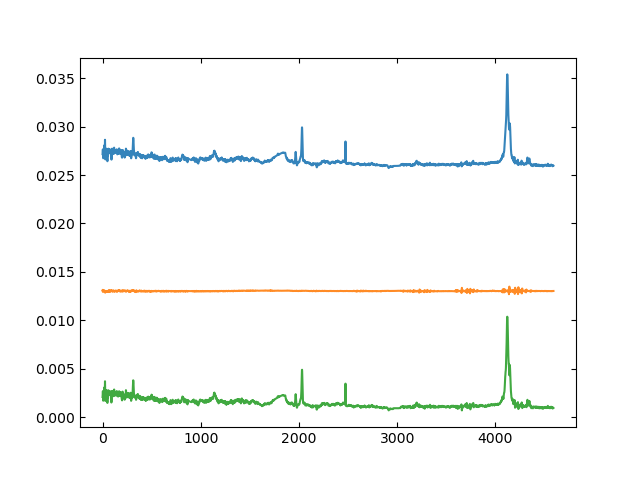

In [7]:
# ----- Plotting the left slit spectra ----- #
fig, ax = plt.subplots()
ax.plot(d_sci[:, 30-1, 30-1]+0.025, alpha=0.9)
ax.plot(lslit_blank+0.013, alpha=0.9)
ax.plot(d_sci_sb[:, 30-1, 30-1], alpha=0.9)